In [51]:
import pandas as pd
import pandasql as ps
import matplotlib.pyplot as plt
import numpy as np

In [52]:
df = pd.read_csv("bio_ws.csv")

In [53]:
ps.sqldf("""
    SELECT * 
    FROM df
    LIMIT 2
""")

,Name,Position,Height,Weight,Academic Year,Hometown,Previous School,Year,School,From_US_State,Is_Transfer,Age,G,MP,OWS,DWS,WS,WS/40,MPG
0,A.J. Hoggard,G,75.0,220.0,Fr.,Pennsylvania,None,2020,Michigan_State,1,0,18.0,26.0,344.0,-0.3,0.4,0.1,0.007,13.230769
1,Aaron Henry,F,78.0,210.0,Jr.,Indiana,None,2020,Michigan_State,1,0,21.0,28.0,910.0,1.5,1.2,2.7,0.119,32.500000


In [79]:
pos = ps.sqldf("""
    SELECT Position, COUNT(*) as cnt
    FROM df
    WHERE Position NOT LIKE "F/C"
    GROUP BY Position
    ORDER BY cnt
""")

pos_tran = ps.sqldf("""
    SELECT Position, COUNT(*) as cnt
    FROM df
    WHERE Is_Transfer == 1
    GROUP BY Position
    ORDER BY cnt
""")
pos_tran

pos_years = {}
for y in range(2020, 2024):
    pos_years[y] = ps.sqldf(f"""
        SELECT Position, COUNT(*) as cnt
        FROM df
        WHERE Year == {y} AND Position NOT LIKE "F/C"
        GROUP BY Position
        ORDER BY cnt
    """)

In [90]:
def pie_chart(pos, description, year=0, ax=None):
    slice_colors = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC66']
    if description == "NBA":
        slice_colors = ['#66B2FF', '#FDF04C', '#FF9999', '#99FF99', '#FFCC66']
    
    if ax is None:  # Create a new figure only if no axis is provided
        fig, ax = plt.subplots(figsize=(5, 5))

    wedges, texts, autotexts = ax.pie(
        pos['cnt'], labels=pos['Position'], autopct='%1.1f%%', 
        startangle=90, colors=slice_colors
    )

    # Remove the "G/F" percentage text and move it outside
    if description != "NBA":
        for i, text in enumerate(autotexts):
            if pos['Position'][i] == 'G/F':
                text.set_text('')
                angle = (wedges[i].theta2 + wedges[i].theta1) / 2
                x = 1.2 * np.cos(np.radians(angle)) + 0.2
                y = 1.2 * np.sin(np.radians(angle)) - 0.1
                pct = f"{100 * pos['cnt'][i] / sum(pos['cnt']):.1f}%"
                ax.annotate(f'{pct}', xy=(x, y), ha='center', va='center', fontsize=9.5, color='black')
                slice_angle = (wedges[i].theta2 + wedges[i].theta1) / 2
                slice_x = np.cos(np.radians(slice_angle)) + 0.01
                slice_y = np.sin(np.radians(slice_angle)) - 0.4
                ax.annotate('', xy=(x - 0.01, y - 0.05), xytext=(slice_x, slice_y), arrowprops=dict(arrowstyle='-', color='black', lw=1.5))

    # Set the title
    text = description + " Position Distribution"
    if year != 0:
        text += " " + year
    ax.set_title(text)
    ax.set_ylabel('')  # Hide the y-label
    
    return ax

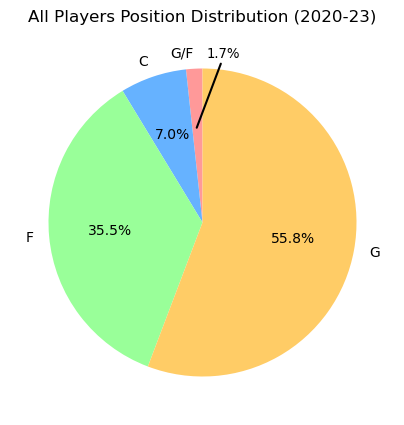

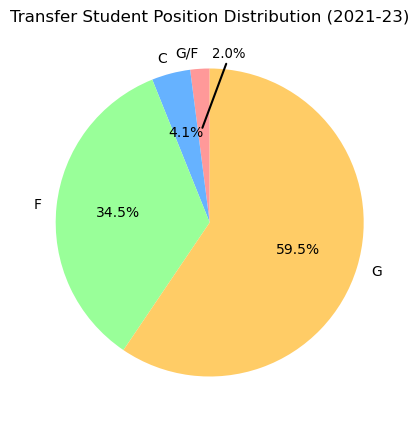

In [92]:
pie_chart(pos, "All Players", "(2020-23)")
plt.savefig('./charts/all_pos.png')

pie_chart(pos_tran, "Transfer Student", "(2021-23)")
plt.savefig('./charts/transfer_pos.png')
plt.show()

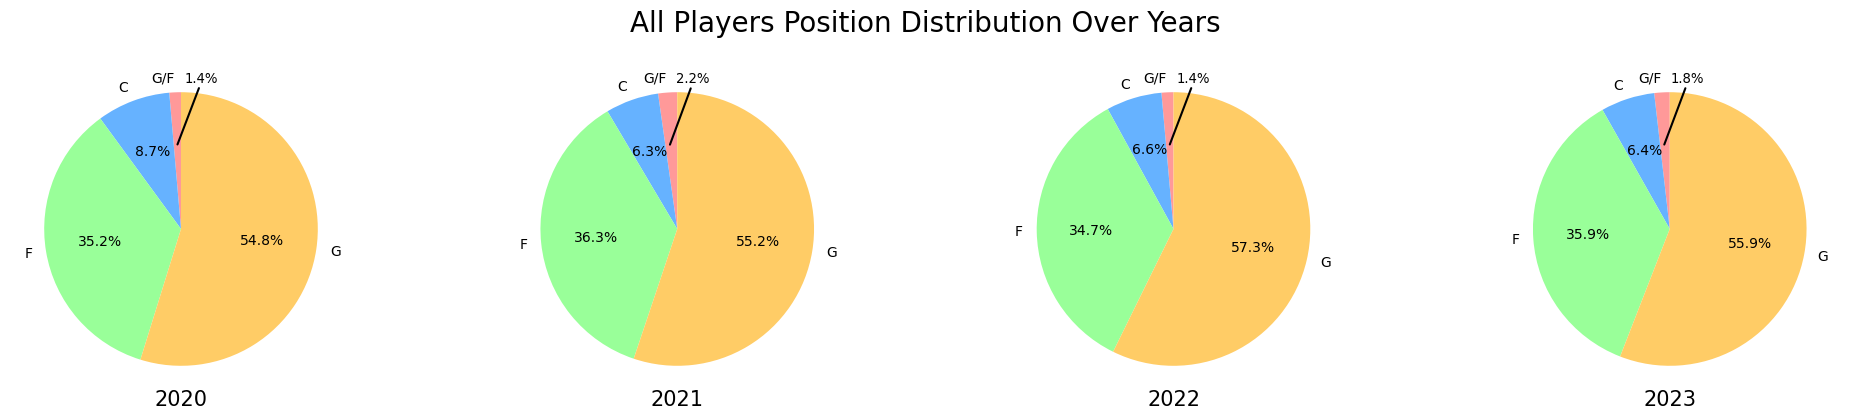

In [95]:
# Set up a 1x4 grid of subplots to place 4 pie charts side by side
fig, axes = plt.subplots(1, 4, figsize=(20, 5))  # Adjust figsize for better spacing if needed

# Loop over each year to plot pie charts in the 1x4 grid
for i, y in enumerate(range(2020, 2024)):
    pie_chart(pos_years[y], "All Players", str(y), ax=axes[i])  # Call pie_chart and pass the appropriate subplot axis
    axes[i].set_title('')
    
    # Place text below each pie chart
    axes[i].text(0.5, 0, f"{y}", 
                 ha='center', va='center', fontsize=15, transform=axes[i].transAxes)
    
# Set a main title for the entire figure
fig.suptitle("All Players Position Distribution Over Years", fontsize=20)
    
# Adjust layout to avoid overlap and ensure text appears as intended
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)  # Add more bottom margin if needed
plt.savefig('./charts/pos_years.png')
plt.show()

In [25]:
nba = pd.read_csv("./nba_data/nba_bio.csv")

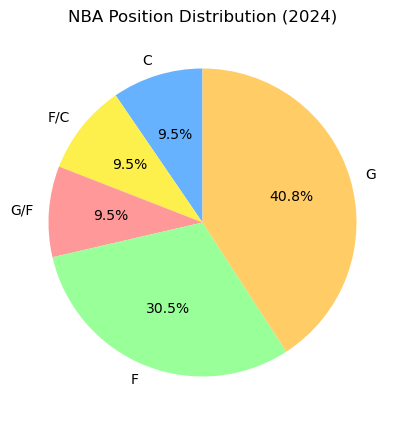

In [93]:
def combine_pos(pos):
    if pos == None:
        return None
    
    if "G" in pos and "F" in pos:
        return "G/F"
    
    if "F" in pos and "C" in pos:
        return "F/C"
    
    return pos

simplified_pos = nba.copy()
simplified_pos["Position"] = simplified_pos["Position"].apply(combine_pos)
pos_nba = ps.sqldf("""
    SELECT Position, COUNT(*) as cnt
    FROM simplified_pos
    WHERE Position NOT LIKE "None"
    GROUP BY Position
    ORDER BY cnt
""")
pie_chart(pos_nba, "NBA", "(2024)")
plt.savefig('./charts/nba_pos.png')

In [84]:
# NBA Body Analysis
nba_body = ps.sqldf("""
    SELECT Position, AVG(Height) as mean_height, AVG(Weight) as mean_weight, COUNT(*) as n
    FROM simplified_pos
    WHERE Position NOT LIKE "None"
    GROUP BY Position
""")

nba_body["mean_height"] = nba_body["mean_height"].apply(lambda x: f"{int(x) // 12}-{int(x) % 12}")
nba_body

,Position,mean_height,mean_weight,n
0,C,6-11,249.14000,50
1,F,6-7,220.15625,160
2,F/C,6-10,241.64000,50
3,G,6-4,197.64486,214
4,G/F,6-6,213.50000,50


In [83]:
# Bigten Body Analysis
bigten_body = ps.sqldf("""
    SELECT Position, AVG(Height) as mean_height, AVG(Weight) as mean_weight, COUNT(*) as n
    FROM df
    WHERE Position NOT LIKE "None"
    GROUP BY Position
""")

bigten_body["mean_height"] = bigten_body["mean_height"].apply(lambda x: f"{int(x) // 12}-{int(x) % 12}")
bigten_body

,Position,mean_height,mean_weight,n
0,C,6-11,246.131148,61
1,F,6-8,226.035714,311
2,F/C,6-9,255.000000,1
3,G,6-3,191.644033,488
4,G/F,6-6,210.733333,15


PandaSQLException: (sqlite3.OperationalError) no such column: None
[SQL: 
    SELECT Age, AVG(MP), COUNT(*) as n
    FROM df
    WHERE MP > 5 and MP != None
    GROUP BY Age
]
(Background on this error at: https://sqlalche.me/e/14/e3q8)